# Data Analysis and Logistic Regression with Customer Profiles

This notebook loads data directly from CSV files, integrates customer profiles from clustering analysis, and performs logistic regression to predict customer response behavior.

In [2]:
# Standard imports
import pandas as pd
import numpy as np
from pathlib import Path

def load_dataset(name: str, filepath: str) -> pd.DataFrame:
    """Load a dataset from CSV with error handling."""
    try:
        df = pd.read_csv(filepath)
        print(f"Loaded {name} data: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading {name}: {e}")
        raise

# Data file configurations
DATA_PATH = Path('data')
data_files = {
    'contact_history': DATA_PATH / 'Contact_History_Fact_0.csv',
    'customer_profiles': DATA_PATH / 'customer_profiles_mapping.csv',
    'customer_score': DATA_PATH / 'Customer_Score_0_RV.csv',
    'campaign': DATA_PATH / 'CH_Campaign_0_V.csv',
    'cell': DATA_PATH / 'CH_Cell_0_V.csv',
    'offer': DATA_PATH / 'CH_Offer_0_V.csv',
    'customer_fact': DATA_PATH / 'Customer_Fact_0_V.csv'
}

# Load all datasets
datasets = {name: load_dataset(name, str(path))
           for name, path in data_files.items()}

# Extract main datasets for easier reference
contact_history_raw = datasets['contact_history']
customer_profiles = datasets['customer_profiles']
customer_score_raw = datasets['customer_score']
campaign_raw = datasets['campaign']
cell_raw = datasets['cell']
offer_raw = datasets['offer']
customer_fact_raw = datasets['customer_fact']

# Display dataset information
print("\nContact History Data Columns:")
print(contact_history_raw.columns.tolist())

print("\nCustomer Profiles Columns:")
print(customer_profiles.columns.tolist())

# Find key columns
key_columns = [col for col in contact_history_raw.columns if col.endswith('key')]
print(f"\nColumns ending with 'key': {key_columns}")

# Display sample data
print("\nFirst few rows of contact history data:")
print(contact_history_raw.head())

print("\nFirst few rows of customer profiles:")
print(customer_profiles.head())

Loaded contact_history data: (1527978, 9)
Loaded customer_profiles data: (190339, 2)
Loaded customer_score data: (1047507, 25)
Loaded campaign data: (55, 7)
Loaded cell data: (17249, 11)
Loaded offer data: (19699, 5)
Loaded customer_score data: (1047507, 25)
Loaded campaign data: (55, 7)
Loaded cell data: (17249, 11)
Loaded offer data: (19699, 5)
Loaded customer_fact data: (1047507, 39)

Contact History Data Columns:
['date_key', 'customer_key', 'customer_score_key', 'ch_campaign_key', 'ch_cell_key', 'ch_offer_key', 'cch_responder_key', 'offer_amount_loc_currency', 'volume']

Customer Profiles Columns:
['customer_key', 'profile_name']

Columns ending with 'key': ['date_key', 'customer_key', 'customer_score_key', 'ch_campaign_key', 'ch_cell_key', 'ch_offer_key', 'cch_responder_key']

First few rows of contact history data:
              date_key  customer_key  customer_score_key  ch_campaign_key  \
0  2018-01-31 00:00:00       5973888           343229725             3671   
1  2018-02-2

In [3]:
# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)

def merge_datasets(datasets: dict) -> pd.DataFrame:
    """Merge all datasets based on their respective keys."""
    # Start with contact history
    merged_data = datasets['contact_history'].copy()
    print(f"\nStarting with contact history data: {merged_data.shape}")

    # Define merge configurations
    merge_configs = [
        ('customer_profiles', 'customer_key'),
        ('customer_score', 'customer_score_key'),
        ('campaign', 'ch_campaign_key'),
        ('cell', 'ch_cell_key'),
        ('offer', 'ch_offer_key')
    ]

    # Perform merges
    for dataset_name, key in merge_configs:
        merged_data = merged_data.merge(
            datasets[dataset_name],
            on=key,
            how='left'
        )
        print(f"After merging with {dataset_name}: {merged_data.shape}")

    return merged_data

# Merge datasets
merged_data = merge_datasets(datasets)

print(f"\nFinal merged dataset shape: {merged_data.shape}")
print(f"Target variable (cch_responder_key) distribution:")
print(merged_data['cch_responder_key'].value_counts(normalize=True))

print(f"\nCustomer profile distribution in merged data:")
print(merged_data['profile_name'].value_counts(normalize=True))


Starting with contact history data: (1527978, 9)
After merging with customer_profiles: (1527978, 10)
After merging with customer_score: (1527978, 34)
After merging with customer_score: (1527978, 34)
After merging with campaign: (1527978, 40)
After merging with campaign: (1527978, 40)
After merging with cell: (1527978, 50)
After merging with cell: (1527978, 50)
After merging with offer: (1527978, 54)

Final merged dataset shape: (1527978, 54)
Target variable (cch_responder_key) distribution:
cch_responder_key
0    0.970597
1    0.029403
Name: proportion, dtype: float64

Customer profile distribution in merged data:
profile_name
Loyal Veterans                    0.252481
Committed Singles                 0.183614
Family Renters                    0.171521
Young Singles                     0.122268
Independent Professionals         0.105017
Established Families              0.070936
Established Homeowner Families    0.055504
Service-Oriented Renters          0.038660
Name: proportion, dt

# Analysis of Offer Products and Sub-products

Analyzing the unique combinations of offer products and their sub-products to understand the product hierarchy and distribution.

In [5]:
# Get unique combinations and their counts
offer_counts = (datasets['offer']
               .groupby(['offer_product', 'offer_sub_product'])
               .size()
               .reset_index(name='count'))

# Sort by product and sub-product
product_combos = (offer_counts
                 .sort_values(['offer_product', 'offer_sub_product'])
                 .reset_index(drop=True))

# Display the combinations with counts in a hierarchical format
print("Offer Product / Sub-product Combinations with Counts:")
print("-" * 60)
current_product = None
for _, row in product_combos.iterrows():
    if row['offer_product'] != current_product:
        current_product = row['offer_product']
        product_total = offer_counts[offer_counts['offer_product'] == current_product]['count'].sum()
        print(f"\nProduct: {current_product} (Total: {product_total:,} offers)")
    pct = (row['count'] / product_total) * 100
    print(f"  └─ {row['offer_sub_product']}: {row['count']:,} offers ({pct:.1f}%)")

# Display summary statistics
print(f"\nSummary:")
print(f"Total unique products: {product_combos['offer_product'].nunique()}")
print(f"Total unique sub-products: {product_combos['offer_sub_product'].nunique()}")
print(f"Total unique combinations: {len(product_combos)}")
print(f"Total number of offers: {product_combos['count'].sum():,}")

# Show product distribution with counts
print("\nProducts by number of sub-products and total offers:")
product_summary = (offer_counts.groupby('offer_product')
                  .agg({
                      'offer_sub_product': 'count',
                      'count': 'sum'
                  })
                  .rename(columns={
                      'offer_sub_product': 'num_sub_products',
                      'count': 'total_offers'
                  })
                  .sort_values('total_offers', ascending=False))
print(product_summary)

# Create a pivot table with counts
pivot_df = pd.crosstab(product_combos['offer_product'],
                       product_combos['offer_sub_product'],
                       values=product_combos['count'],
                       aggfunc='sum',
                       margins=True)

print("\nProduct/Sub-product Count Matrix:")
print(pivot_df)

# Save the combinations with counts to a CSV file for reference
output_file = 'Data/offer_product_combinations.csv'
product_combos.to_csv(output_file, index=False)
print(f"\nCombinations with counts saved to: {output_file}")

# Display percentage distribution
print("\nPercentage Distribution of Offers:")
total_offers = product_combos['count'].sum()
for product in product_combos['offer_product'].unique():
    product_offers = product_combos[product_combos['offer_product'] == product]
    product_total = product_offers['count'].sum()
    product_pct = (product_total / total_offers) * 100
    print(f"\n{product} ({product_pct:.1f}% of all offers):")

Offer Product / Sub-product Combinations with Counts:
------------------------------------------------------------

Product: Credit Card (Total: 12,428 offers)
  └─ .: 1,966 offers (15.8%)
  └─ Credit Card: 235 offers (1.9%)
  └─ MC~AADVANTAGE: 351 offers (2.8%)
  └─ MC~GOLD: 2,498 offers (20.1%)
  └─ MC~MAGNA: 226 offers (1.8%)
  └─ MC~PLATINUM: 1,116 offers (9.0%)
  └─ MC~PSMT: 6 offers (0.0%)
  └─ MC~STANDARD: 309 offers (2.5%)
  └─ PA 2nd Card: 361 offers (2.9%)
  └─ PA CC: 301 offers (2.4%)
  └─ PA CC - NBSF: 58 offers (0.5%)
  └─ VS~AADVANTAGE: 5 offers (0.0%)
  └─ VS~AADVPLAT: 731 offers (5.9%)
  └─ VS~CLASSIC: 854 offers (6.9%)
  └─ VS~GOLD: 1,270 offers (10.2%)
  └─ VS~PLATINUM: 1,864 offers (15.0%)
  └─ VS~STANDARD: 107 offers (0.9%)
  └─ X: 170 offers (1.4%)

Product: SPL (Total: 5,392 offers)
  └─ PA SPL: 169 offers (3.1%)
  └─ PA SPL TopUp: 166 offers (3.1%)
  └─ SPL: 3,274 offers (60.7%)
  └─ SPL TopUp: 1,783 offers (33.1%)

Product: Scotialine (Total: 1,879 offers)
  └─ 

In [7]:
# Create markdown table output
markdown_output = ["# Offer Product Analysis\n"]

# Overall summary
total_offers = product_combos['count'].sum()
markdown_output.append("## Summary Statistics")
markdown_output.append(f"- Total number of offers: {total_offers:,}")
markdown_output.append(f"- Unique products: {product_combos['offer_product'].nunique()}")
markdown_output.append(f"- Unique sub-products: {product_combos['offer_sub_product'].nunique()}")
markdown_output.append(f"- Unique combinations: {len(product_combos)}")
markdown_output.append("\n> Note: SPL stands for 'Star Plan Loan', which is a personal loan product.\n")

# Product summary table
markdown_output.append("## Product Summary")
markdown_output.append("| Product | Description | Sub-products | Total Offers | % of Total |")
markdown_output.append("|---------|-------------|--------------|--------------|------------|")

for product in product_combos['offer_product'].unique():
    product_data = product_combos[product_combos['offer_product'] == product]
    num_sub_products = len(product_data)
    total_product_offers = product_data['count'].sum()
    pct_total = (total_product_offers / total_offers) * 100

    # Add description for SPL
    description = "Star Plan Loan (Personal Loan)" if product == "SPL" else ""

    markdown_output.append(
        f"| {product} | {description} | {num_sub_products} | {total_product_offers:,} | {pct_total:.1f}% |"
    )

# Detailed breakdown by product
markdown_output.append("\n## Detailed Breakdown by Product")
for product in product_combos['offer_product'].unique():
    # Add SPL explanation in the header
    if product == "SPL":
        markdown_output.append(f"\n### {product} - Star Plan Loan (Personal Loan)")
    else:
        markdown_output.append(f"\n### {product}")

    markdown_output.append("| Sub-product | Offers | % of Product |")
    markdown_output.append("|------------|---------|--------------|")

    product_data = product_combos[product_combos['offer_product'] == product]
    product_total = product_data['count'].sum()

    for _, row in product_data.iterrows():
        pct_product = (row['count'] / product_total) * 100
        markdown_output.append(
            f"| {row['offer_sub_product']} | {row['count']:,} | {pct_product:.1f}% |"
        )

# Join all lines with newlines
markdown_text = '\n'.join(markdown_output)

# Display as markdown
from IPython.display import Markdown, display
display(Markdown(markdown_text))

# Offer Product Analysis

## Summary Statistics
- Total number of offers: 19,699
- Unique products: 3
- Unique sub-products: 26
- Unique combinations: 27

> Note: SPL stands for 'Star Plan Loan', which is a personal loan product.

## Product Summary
| Product | Description | Sub-products | Total Offers | % of Total |
|---------|-------------|--------------|--------------|------------|
| Credit Card |  | 18 | 12,428 | 63.1% |
| SPL | Star Plan Loan (Personal Loan) | 4 | 5,392 | 27.4% |
| Scotialine |  | 5 | 1,879 | 9.5% |

## Detailed Breakdown by Product

### Credit Card
| Sub-product | Offers | % of Product |
|------------|---------|--------------|
| . | 1,966 | 15.8% |
| Credit Card | 235 | 1.9% |
| MC~AADVANTAGE | 351 | 2.8% |
| MC~GOLD | 2,498 | 20.1% |
| MC~MAGNA | 226 | 1.8% |
| MC~PLATINUM | 1,116 | 9.0% |
| MC~PSMT | 6 | 0.0% |
| MC~STANDARD | 309 | 2.5% |
| PA 2nd Card | 361 | 2.9% |
| PA CC | 301 | 2.4% |
| PA CC - NBSF | 58 | 0.5% |
| VS~AADVANTAGE | 5 | 0.0% |
| VS~AADVPLAT | 731 | 5.9% |
| VS~CLASSIC | 854 | 6.9% |
| VS~GOLD | 1,270 | 10.2% |
| VS~PLATINUM | 1,864 | 15.0% |
| VS~STANDARD | 107 | 0.9% |
| X | 170 | 1.4% |

### SPL - Star Plan Loan (Personal Loan)
| Sub-product | Offers | % of Product |
|------------|---------|--------------|
| PA SPL | 169 | 3.1% |
| PA SPL TopUp | 166 | 3.1% |
| SPL | 3,274 | 60.7% |
| SPL TopUp | 1,783 | 33.1% |

### Scotialine
| Sub-product | Offers | % of Product |
|------------|---------|--------------|
| PA SL | 108 | 5.7% |
| PA SLG | 98 | 5.2% |
| SL | 933 | 49.7% |
| SLG | 671 | 35.7% |
| X | 69 | 3.7% |

# Conversion Analysis by Customer Profile and Offer Product

Analyzing how different customer profiles respond to various offer products. A conversion (response) is indicated by `cch_responder_key = 1`.

In [9]:
# Calculate conversions by customer profile and offer product
conversion_analysis = (merged_data
    .groupby(['profile_name', 'offer_product'])
    .agg({
        'cch_responder_key': ['count', 'sum']  # count = total offers, sum = conversions
    })
    .reset_index())

# Rename columns for clarity
conversion_analysis.columns = ['profile_name', 'offer_product', 'total_offers', 'conversions']

# Calculate conversion rates and sort by total offers
conversion_analysis['conversion_rate'] = (
    conversion_analysis['conversions'] / conversion_analysis['total_offers'] * 100
)
conversion_analysis = conversion_analysis.sort_values('total_offers', ascending=False)

# Create markdown tables for the analysis
markdown_output = ["## Conversion Analysis Results\n"]

# Overall summary
total_offers = conversion_analysis['total_offers'].sum()
total_conversions = conversion_analysis['conversions'].sum()
overall_rate = (total_conversions / total_offers) * 100

markdown_output.append("### Overall Summary")
markdown_output.append(f"- Total offers made: {total_offers:,}")
markdown_output.append(f"- Total conversions: {total_conversions:,}")
markdown_output.append(f"- Overall conversion rate: {overall_rate:.2f}%\n")

# By customer profile
markdown_output.append("### Conversion Rates by Customer Profile")
markdown_output.append("| Profile | Total Offers | Conversions | Conversion Rate |")
markdown_output.append("|---------|--------------|-------------|-----------------|")

profile_summary = conversion_analysis.groupby('profile_name').agg({
    'total_offers': 'sum',
    'conversions': 'sum'
}).reset_index()
profile_summary['conversion_rate'] = (
    profile_summary['conversions'] / profile_summary['total_offers'] * 100
)
profile_summary = profile_summary.sort_values('total_offers', ascending=False)

for _, row in profile_summary.iterrows():
    markdown_output.append(
        f"| {row['profile_name']} | {row['total_offers']:,} | "
        f"{row['conversions']:,} | {row['conversion_rate']:.2f}% |"
    )

# By offer product
markdown_output.append("\n### Conversion Rates by Offer Product")
markdown_output.append("| Product | Total Offers | Conversions | Conversion Rate |")
markdown_output.append("|---------|--------------|-------------|-----------------|")

product_summary = conversion_analysis.groupby('offer_product').agg({
    'total_offers': 'sum',
    'conversions': 'sum'
}).reset_index()
product_summary['conversion_rate'] = (
    product_summary['conversions'] / product_summary['total_offers'] * 100
)
product_summary = product_summary.sort_values('total_offers', ascending=False)

for _, row in product_summary.iterrows():
    product_name = "Star Plan Loan" if row['offer_product'] == "SPL" else row['offer_product']
    markdown_output.append(
        f"| {product_name} | {row['total_offers']:,} | "
        f"{row['conversions']:,} | {row['conversion_rate']:.2f}% |"
    )

# Detailed breakdown - sorted by profile and product
markdown_output.append("\n### Detailed Breakdown by Profile and Product")
markdown_output.append("| Profile | Product | Total Offers | Conversions | Conversion Rate |")
markdown_output.append("|---------|---------|--------------|-------------|-----------------|")

# Sort conversion_analysis by profile_name and offer_product
sorted_analysis = conversion_analysis.sort_values(['profile_name', 'offer_product'])

for _, row in sorted_analysis.iterrows():
    product_name = "Star Plan Loan" if row['offer_product'] == "SPL" else row['offer_product']
    markdown_output.append(
        f"| {row['profile_name']} | {product_name} | {row['total_offers']:,} | "
        f"{row['conversions']:,} | {row['conversion_rate']:.2f}% |"
    )

# Display the markdown tables
from IPython.display import Markdown, display
display(Markdown('\n'.join(markdown_output)))

## Conversion Analysis Results

### Overall Summary
- Total offers made: 1,527,978
- Total conversions: 44,927
- Overall conversion rate: 2.94%

### Conversion Rates by Customer Profile
| Profile | Total Offers | Conversions | Conversion Rate |
|---------|--------------|-------------|-----------------|
| Loyal Veterans | 385,785 | 10,468 | 2.71% |
| Committed Singles | 280,558 | 7,707 | 2.75% |
| Family Renters | 262,080 | 6,883 | 2.63% |
| Young Singles | 186,823 | 4,436 | 2.37% |
| Independent Professionals | 160,464 | 4,095 | 2.55% |
| Established Families | 108,388 | 2,573 | 2.37% |
| Established Homeowner Families | 84,809 | 1,892 | 2.23% |
| Service-Oriented Renters | 59,071 | 6,873 | 11.64% |

### Conversion Rates by Offer Product
| Product | Total Offers | Conversions | Conversion Rate |
|---------|--------------|-------------|-----------------|
| Star Plan Loan | 813,184 | 28,271 | 3.48% |
| Credit Card | 649,968 | 15,634 | 2.41% |
| Scotialine | 64,826 | 1,022 | 1.58% |

### Detailed Breakdown by Profile and Product
| Profile | Product | Total Offers | Conversions | Conversion Rate |
|---------|---------|--------------|-------------|-----------------|
| Committed Singles | Credit Card | 122,487 | 3,114 | 2.54% |
| Committed Singles | Star Plan Loan | 150,876 | 4,456 | 2.95% |
| Committed Singles | Scotialine | 7,195 | 137 | 1.90% |
| Established Families | Credit Card | 45,967 | 793 | 1.73% |
| Established Families | Star Plan Loan | 55,981 | 1,706 | 3.05% |
| Established Families | Scotialine | 6,440 | 74 | 1.15% |
| Established Homeowner Families | Credit Card | 36,918 | 663 | 1.80% |
| Established Homeowner Families | Star Plan Loan | 42,911 | 1,178 | 2.75% |
| Established Homeowner Families | Scotialine | 4,980 | 51 | 1.02% |
| Family Renters | Credit Card | 111,960 | 2,540 | 2.27% |
| Family Renters | Star Plan Loan | 141,082 | 4,200 | 2.98% |
| Family Renters | Scotialine | 9,038 | 143 | 1.58% |
| Independent Professionals | Credit Card | 68,444 | 1,363 | 1.99% |
| Independent Professionals | Star Plan Loan | 84,415 | 2,620 | 3.10% |
| Independent Professionals | Scotialine | 7,605 | 112 | 1.47% |
| Loyal Veterans | Credit Card | 159,392 | 3,297 | 2.07% |
| Loyal Veterans | Star Plan Loan | 203,708 | 6,901 | 3.39% |
| Loyal Veterans | Scotialine | 22,685 | 270 | 1.19% |
| Service-Oriented Renters | Credit Card | 26,782 | 2,168 | 8.09% |
| Service-Oriented Renters | Star Plan Loan | 29,616 | 4,532 | 15.30% |
| Service-Oriented Renters | Scotialine | 2,673 | 173 | 6.47% |
| Young Singles | Credit Card | 78,018 | 1,696 | 2.17% |
| Young Singles | Star Plan Loan | 104,595 | 2,678 | 2.56% |
| Young Singles | Scotialine | 4,210 | 62 | 1.47% |

Conversion Analysis Columns: profile_name        object
offer_product       object
total_offers         int64
conversions          int64
conversion_rate    float64
dtype: object

Sample of conversion_analysis data:
         profile_name offer_product  total_offers  conversions  \
16     Loyal Veterans           SPL        203708         6901   
15     Loyal Veterans   Credit Card        159392         3297   
1   Committed Singles           SPL        150876         4456   
10     Family Renters           SPL        141082         4200   
0   Committed Singles   Credit Card        122487         3114   

    conversion_rate  
16         3.387692  
15         2.068485  
1          2.953419  
10         2.976992  
0          2.542311  

Conversions pivot table shape: (3, 8)
Rates pivot table shape: (3, 8)


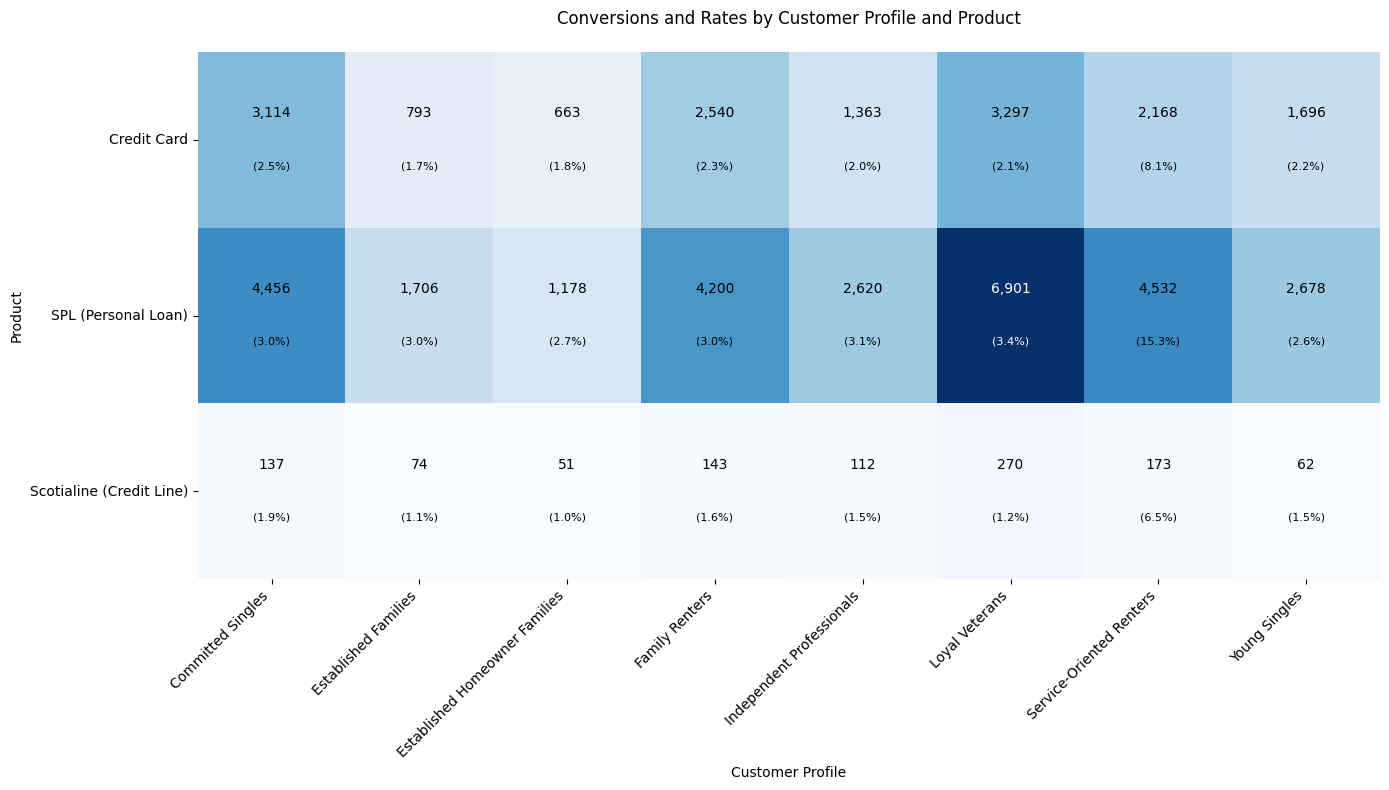

In [17]:
# Create a heatmap of conversion rates by profile and product
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Print data types and sample values for debugging
print("Conversion Analysis Columns:", conversion_analysis.dtypes)
print("\nSample of conversion_analysis data:")
print(conversion_analysis.head())

# Create two pivot tables - one for conversions and one for rates
conversions_data = conversion_analysis.pivot(
    index='offer_product',
    columns='profile_name',
    values='conversions'
)

rates_data = conversion_analysis.pivot(
    index='offer_product',
    columns='profile_name',
    values='conversion_rate'
)

# Print pivot table info for debugging
print("\nConversions pivot table shape:", conversions_data.shape)
print("Rates pivot table shape:", rates_data.shape)

# Create a figure with appropriate size
plt.figure(figsize=(14, 8))

# Create a mapping for product labels
product_labels = {
    'SPL': 'SPL (Personal Loan)',
    'Scotialine': 'Scotialine (Credit Line)'
}

# Update the index labels
conversions_data.index = [product_labels.get(prod, prod) for prod in conversions_data.index]

# Create heatmap with explicit vmin and vmax
vmax = conversions_data.values.max()
vmin = conversions_data.values.min()

ax = sns.heatmap(
    conversions_data,
    annot=False,  # We'll add annotations manually
    cmap='Blues',  # Use blue color scheme
    vmin=vmin,
    vmax=vmax,
    cbar=False  # Remove the colorbar
)

# Add annotations with both conversion numbers and rates
for i in range(len(conversions_data.index)):
    for j in range(len(conversions_data.columns)):
        conversions = conversions_data.iloc[i, j]
        rate = rates_data.iloc[i, j]

        # Calculate color based on value
        norm_val = (conversions - vmin) / (vmax - vmin)
        text_color = 'white' if norm_val > 0.7 else 'black'  # Adjusted threshold for blue colormap

        # Add conversion number
        ax.text(j + 0.5, i + 0.35, f'{conversions:,.0f}',
                ha='center', va='center',
                color=text_color)

        # Add rate in smaller font below
        ax.text(j + 0.5, i + 0.65, f'({rate:.1f}%)',
                ha='center', va='center',
                color=text_color,
                fontsize=8)

# Customize the plot
plt.title('Conversions and Rates by Customer Profile and Product', pad=20)
plt.xlabel('Customer Profile')
plt.ylabel('Product')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()